In [1]:
%load_ext autoreload
%autoreload 2

# Training the VAE

In [2]:
import numpy as np
from keras import callbacks

from utils import data_generation
import vae_model

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\vecse\Anaconda3\envs\kaggle\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Model

In [3]:
vae = vae_model.VAE(latent_dim=32, reconstruction_loss=vae_model.ReconstructionLoss.MSE)

### Complete model (encoder + decoder)

In [4]:
vae.vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
model_2 (Model)              (None, 32)                264032    
_________________________________________________________________
model_3 (Model)              (None, 64, 64, 3)         232483    
Total params: 496,515
Trainable params: 496,515
Non-trainable params: 0
_________________________________________________________________


### Encoder

In [5]:
vae.encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 31, 32)        1568      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        32832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 64)          65600     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 128)         131200    
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                16416     
Total para

### Decoder

In [6]:
vae.decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1600)              52800     
_________________________________________________________________
reshape_1 (Reshape)          (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 13, 13, 64)        102464    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 30, 30, 32)        73760     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 64, 64, 3)         3459      
Total params: 232,483
Trainable params: 232,483
Non-trainable params: 0
_________________________________________________________________


## Generating the training data

In [7]:
nb_images = 100
image_width = 64
image_height = 64

images = np.zeros((nb_images, image_height, image_width, 3), dtype=np.uint8)

for i, x in enumerate(data_generation.rnd_circle_data_generator(nb_images,
                                                                image_width,
                                                                image_height,
                                                                (0, image_width),
                                                                (0, image_height),
                                                                (6, 24))):
    images[i] = x

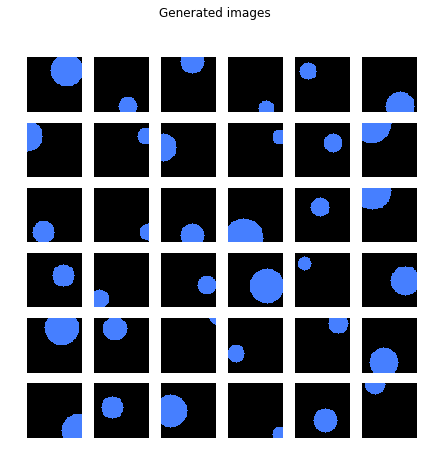

In [8]:
fig, axs = plt.subplots(6, 6, figsize=(7, 7))
fig.suptitle("Generated images")

for i, ax in enumerate(axs.flatten()):
    ax.axis("off")
    ax.imshow(images[i])

In [9]:
images = images.astype(np.float16) / 255.0

## Trainign the VAE

In [10]:
# early_stopping = callbacks.EarlyStopping(monitor="loss", patience=10, verbose=1, restore_best_weights=True)

In [11]:
train_hist = vae.vae.fit(images, images, epochs=500, batch_size=64, validation_split=0.2, callbacks=[], verbose=0)

### Saving weights

In [12]:
vae.vae.save_weights("./saved_weights/circle_test.h5")

### Plots from training

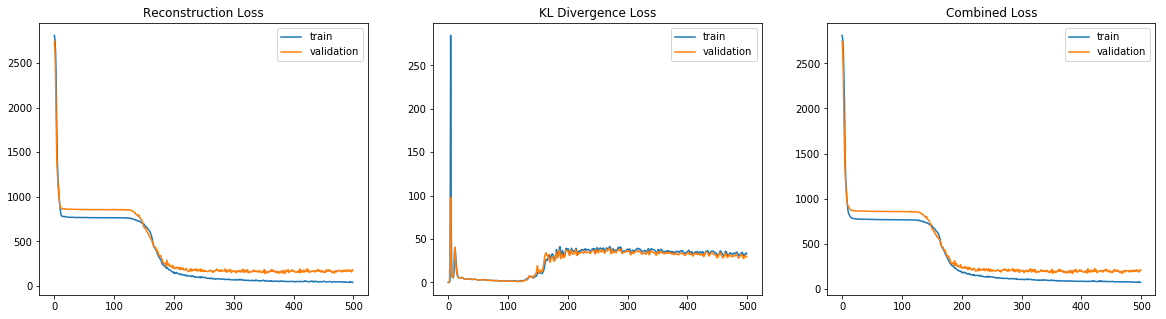

In [13]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 5))

ax0.set_title("Reconstruction Loss")
ax0.plot(train_hist.history["reconstruction"], label="train")
ax0.plot(train_hist.history["val_reconstruction"], label="validation")
ax0.legend()

ax1.set_title("KL Divergence Loss")
ax1.plot(train_hist.history["kl_divergence"], label="train")
ax1.plot(train_hist.history["val_kl_divergence"], label="validation")
ax1.legend()

ax2.set_title("Combined Loss")
ax2.plot(train_hist.history["loss"], label="train")
ax2.plot(train_hist.history["val_loss"], label="validation")
ax2.legend();

## Test the model

### Encode images to a latent vector

In [14]:
encoded_images = vae.encoder.predict(images)

In [15]:
encoded_images.shape

(100, 32)

### Decode images

In [16]:
decoded_images = vae.decoder.predict(encoded_images)

In [17]:
decoded_images = (decoded_images * 255.0).astype(np.uint8)

In [18]:
decoded_images.shape

(100, 64, 64, 3)

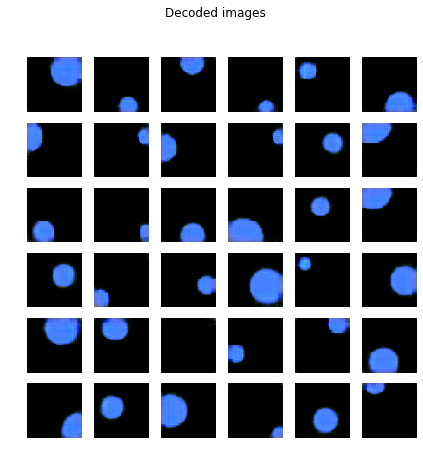

In [19]:
fig, axs = plt.subplots(6, 6, figsize=(7, 7))
fig.suptitle("Decoded images")

for i, ax in enumerate(axs.flatten()):
    ax.axis("off")
    ax.imshow(decoded_images[i])